In [2]:
import pandas as pd
import numpy as np
from pandas import DataFrame, Series
import seaborn as sns

import time
import re

import MySQLdb
import matplotlib.pyplot as plt
sns.set_style('whitegrid')
%matplotlib inline

In [3]:
def get_ccf(conn):
    sql_ccf = "SELECT * FROM ccf"
    df_ccf = pd.read_sql(sql_ccf, conn)
    return df_ccf

def get_core(conn):
    sql_core = "SELECT * FROM core"
    df_core = pd.read_sql(sql_core, conn)
    return df_core

In [4]:
#sql_ip = "shhr.online" #数据库地址
#port = 33755 #数据库端口号
sql_ip = "192.168.1.198"
#sql_ip = "127.0.0.1"
port = 3306
user = "jingfei" #用户名
passwd = "hanjingfei007"
db = "aminer_gai"
conn = MySQLdb.connect(host=sql_ip, user=user, port=port, passwd=passwd, db=db, charset='utf8')

In [5]:
path = "/home/jingfei/data/MAG/"

# Get all fields of study in computer science -[No use]

In [100]:
df_fos = pd.read_table(path+"FieldsOfStudy.txt", names=['fos_id', 'fos_name'])
df_fosh = pd.read_table(path+"FieldOfStudyHierarchy.txt", names=['fosh_child_id', 'fosh_child_level', 'fosh_parent_id', 'fosh_parent_level', 'fosh_confidence'])

In [129]:
df_fos = df_fos.dropna()

In [130]:
print df_fos.info()
print df_fosh.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53833 entries, 0 to 53833
Data columns (total 2 columns):
fos_id      53833 non-null object
fos_name    53833 non-null object
dtypes: object(2)
memory usage: 1.2+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182103 entries, 0 to 182102
Data columns (total 5 columns):
fosh_child_id        182103 non-null object
fosh_child_level     182103 non-null object
fosh_parent_id       182103 non-null object
fosh_parent_level    182103 non-null object
fosh_confidence      182103 non-null float64
dtypes: float64(1), object(4)
memory usage: 6.9+ MB
None


In [104]:
#This is all L0 field. and we get computer science is: 0271BC14

#df_tmp = df_fosh[df_fosh['fosh_parent_level']=='L0']\
#[['fosh_parent_id', 'fosh_parent_level']].drop_duplicates(['fosh_parent_id'])
#df_tmp.merge(df_fos, left_on='fosh_parent_id', right_on='fos_id')

In fos table, 1 item's fos_name is **NAN**, we need to delete it.

We get the computer science fos_id: **0271BC14**

In [131]:
#Get all fields whose parent id is 0271BC14
df_tmp=df_fosh[df_fosh['fosh_parent_id']=='0271BC14'].drop_duplicates(['fosh_child_id'])
df_tmp2 = df_tmp.merge(df_fos, left_on='fosh_child_id', right_on='fos_id')

In [132]:
df_tmp2.groupby(['fosh_child_level']).size()

fosh_child_level
L1      35
L2     279
L3    4866
dtype: int64

In the fields whose parent is computer science, there are **35 in *L1*, 279 in *L2*, 
4866 in *L3***.

In [142]:
# #Check the fields which contains particular string and order it by confidence.
# df_tmp2[df_tmp2['fos_name'].str.lower()\
#         .str.contains("neural network")].sort_values(by='fosh_confidence')
# df_tmp2.sort_values(by='fosh_confidence')
#df_tmp2.fosh_confidence.describe()
#df_tmp2

# Match venues with CCF and CORE

In [6]:
df_conference = pd.read_table(path+"Conferences.txt", \
                              names=['con_id', 'con_abbr','con_name'])
df_journal = pd.read_table(path+"Journals.txt", names=['jour_id', 'jour_name'])
df_instance = pd.read_table(path+"ConferenceInstances.txt", \
                     names=['ins_series_id', 'ins_id', 'abbr', 'full_name', 'location',\
                           'conference_url', 'start_date', 'end_date', 'regis_date',\
                           'deadline_date', 'due_date', 'final_due_date'])


In [17]:
#Check particular conferences instances

df_instance[df_instance.abbr.str.contains("ICCV") & df_instance.ins_series_id.notnull()].sort_values(by='abbr', ascending=True)

,ins_series_id,ins_id,abbr,full_name,location,conference_url,start_date,end_date,regis_date,deadline_date,due_date,final_due_date
26125,45701BF3,0C428A10,ICCV 2009,ICCV 2009 : International Conference on Comput...,"Kyoto, Japan",http://www.iccv2009.org/,2009/09/29,2009/10/02,NaN,2009/03/10,2009/06/15,2009/07/15
14543,45701BF3,0439CB3B,ICCV 2011,ICCV 2011 : The 13th International Conference ...,"Barcelona, Spain",http://www.iccv2011.org/,2011/11/06,2011/11/13,NaN,2011/03/01,NaN,NaN
20358,45701BF3,0A118C7A,ICCV 2013,ICCV 2013 : IEEE International Conference on C...,"Sydney, Australia",http://www.iccv2013.org/,2013/12/01,2013/12/08,2013/04/08,2013/04/12,NaN,NaN
48363,45701BF3,272265A7,ICCV 2015,ICCV 2015 : International Conference on Comput...,"Santiago, Chile",NaN,2015/12/11,2015/12/18,NaN,2015/04/01,NaN,NaN
2982,4756C1ED,0A629BC2,ICCVG 2010,ICCVG 2010 : International Conference on Compu...,Warsaw,http://www.iccvg2010.pjwstk.edu.pl/default.asp,2010/09/20,2010/09/22,NaN,2010/03/01,2010/04/30,2010/05/30
13626,4756C1ED,07C16B1F,ICCVG 2012,ICCVG 2012 : International Conference on Compu...,Warsaw,http://iccvg2012.pjwstk.edu.pl/default.asp,2012/09/24,2012/09/26,NaN,2012/04/30,2012/05/19,2012/05/31


For Conference, Journals and Conference Instances, we can get following infomation:
1. 1283 items in df_conference, not exist NAN, and include id, abbr, full name
2. 23404 items in df_journal, not exist NAN, and include id, full name
3. 50202 items in df_instance, three attributes including ins_id, abbr, full name is not null. What's more, only 6170 items have ins_series_id

**[<font color=#ff0000>NOTICE</font>]:** Some conferences are held every **2 years**!

Considering the journal's match is difficult, we first consider only conference.

In [163]:
df_ccf = get_ccf(conn)
df_core = get_core(conn)

DatabaseError: Execution failed on sql: SELECT * FROM ccf
(2006, 'MySQL server has gone away')
unable to rollback

In [164]:
#df_ccf.loc[df_ccf['CCF_abbreviation'] == 'SIGKDD', 'CCF_abbreviation']='KDD'
#df_core.loc[df_core['CORE_abbreviation'] == 'SIGKDD', 'CORE_abbreviation']='KDD'

In [165]:
df_ccf_conference = df_ccf[df_ccf['CCF_type']=='conference']\
[['CCF_id', 'CCF_name', 'CCF_abbreviation', 'CCF_classification', 'computercategory_computerCategory_id']]
df_core_conference = df_core[df_core['CORE_type'] == 'conference']\
[['CORE_id', 'CORE_name', 'CORE_abbreviation', 'CORE_classification']]
df_ccf_conference.columns = ['CCF_id', 'CCF_name', 'CCF_abbreviation', 'CCF_classification', 'CCF_category']

There are **312** conferences in CCF all of which are NOT NULL and **1687** conferences in CORE all of which are NOT NULL.

What's more, no conference has mutlti-name.

In [237]:
df_ccf_conference.head()

,CCF_id,CCF_name,CCF_abbreviation,CCF_classification,CCF_category
24,25,International Conference on Architectural Supp...,ASPLOS,A,1
25,26,USENIX Conference on File and Storage Technolo...,FAST,A,1
26,27,International Symposium on High-Performance Co...,HPCA,A,1
27,28,International Symposium on Computer Architecture,ISCA,A,1
28,29,International Symposium on Microarchitecture,MICRO,A,1


In [166]:
#df_conference's abbr is not unique. we must drop duplicates. JUST HAVE ONE.
#df_conference = df_conference[df_conference.drop_duplicates(['con_abbr'])]
df_conference = df_conference.drop_duplicates(['con_abbr'])
df_ccf_conference = df_ccf_conference.drop_duplicates(['CCF_abbreviation'])
df_core_conference = df_core_conference.drop_duplicates(['CORE_abbreviation'])

In [151]:
dic= {
    "ESEC/FSE": "FSE",
    "SIGKDD": "KDD",
    "ACM MM": "MM",
    "ECML-PKDD": "PKDD",
    "ACMMM":"MM",
    "EuroPar":"ICPP",
    "IEEE-MM":"ICMCS",
    "JICSLP/ICLP/ILPS":"ICLP",
    "MATES ENASE":"MATES",
    "ACE (DIMEA)":"DIMEA",
    "AsiaCCS":"CCS",
    "EuAda":"Ada-Europe",
}

In [167]:
#CORE abbreviation normalization
Normalize_abbr = []
for i in df_core_conference['CORE_abbreviation']:
    if len(i)>5 and i[:5]=='IEEE ':
        Normalize_abbr.append(i[5:].upper())
        #print i[5:]
    else:
        Normalize_abbr.append(i.upper())
df_core_conference['CORE_normalize_abbr'] = Normalize_abbr

In [168]:
#CCF abbreviation normalization
Normalize_abbr = []
for i in df_ccf_conference['CCF_abbreviation']:
    if len(i)>5 and i[:5]=='IEEE ':
        Normalize_abbr.append(i[5:].upper())
        #print i[5:]
    else:
        Normalize_abbr.append(i.upper())
df_ccf_conference['CCF_normalize_abbr'] = Normalize_abbr

In [182]:
df_conference["Con_normalize_abbr"] = df_conference.con_abbr.str.upper()

In [183]:
df_core_conference.CORE_normalize_abbr = df_core_conference.CORE_normalize_abbr.replace(dic)
df_ccf_conference.CCF_normalize_abbr = df_ccf_conference.CCF_normalize_abbr.replace(dic)

In [196]:
df_tmp1 = pd.merge(df_conference, df_core_conference, left_on='Con_normalize_abbr', right_on='CORE_normalize_abbr')
df_tmp2 = pd.merge(df_conference, df_ccf_conference, left_on='Con_normalize_abbr', right_on='CCF_normalize_abbr')

In [197]:
df_tmp1.columns

Index([u'con_id', u'con_abbr', u'con_name', u'Con_normalize_abbr', u'CORE_id',
       u'CORE_name', u'CORE_abbreviation', u'CORE_classification',
       u'CORE_normalize_abbr'],
      dtype='object')

In [198]:
df_tmp2.columns

Index([u'con_id', u'con_abbr', u'con_name', u'Con_normalize_abbr', u'CCF_id',
       u'CCF_name', u'CCF_abbreviation', u'CCF_classification',
       u'CCF_category', u'CCF_normalize_abbr'],
      dtype='object')

In [199]:
df_tmp3 = pd.merge(df_tmp1, df_tmp2, how='outer')

In [203]:
df_tmp3[(df_tmp3.CCF_id.notnull()) & (df_tmp3.CORE_id.notnull())]

,con_id,con_abbr,con_name,Con_normalize_abbr,CORE_id,CORE_name,CORE_abbreviation,CORE_classification,CORE_normalize_abbr,CCF_id,CCF_name,CCF_abbreviation,CCF_classification,CCF_category,CCF_normalize_abbr
5,45D14EDE,UbiComp,Ubiquitous Computing,UBICOMP,1825.0,Ubiquitous Computing,UbiComp,A*,UBICOMP,522.0,ACM International Conference on Ubiquitous Com...,UbiComp,A,9.0,UBICOMP
8,4761B00F,NSPW,New Security Paradigms Workshop,NSPW,1642.0,New Security Paradigms Workshop,NSPW,C,NSPW,179.0,New Security Paradigms Workshop,NSPW,C,3.0,NSPW
10,42C7B402,WSDM,Web Search and Data Mining,WSDM,31.0,ACM International Conference on Web Search and...,WSDM,A*,WSDM,306.0,ACM International Conference on Web Search and...,WSDM,C,5.0,WSDM
12,4372B502,ICMI,International Conference on Multimodal Interfaces,ICMI,1144.0,International Conference on Multimodal Interfaces,ICMI,B,ICMI,537.0,ACM International Conference on Multimodal Int...,ICMI,C,9.0,ICMI
13,43A23F32,SECON,"Sensor, Mesh and Ad Hoc Communications and Net...",SECON,610.0,"IEEE Conference on Sensor, Mesh and Ad Hoc Com...",SECON,B,SECON,106.0,Annual IEEE Communications Society Conference ...,SECON,B,2.0,SECON
15,43B946B8,SOUPS,Symposium On Usable Privacy and Security,SOUPS,2167.0,Symposium On Usable Privacy and Security,SOUPS,B,SOUPS,181.0,Symposium On Usable Privacy and Security,SOUPS,C,3.0,SOUPS
17,45F914AD,NAACL,North American Chapter of the Association for ...,NAACL,1648.0,North American Association for Computational L...,NAACL,A,NAACL,509.0,North American Chapter of the Association for ...,NAACL,C,8.0,NAACL
23,479D4D98,CP,Principles and Practice of Constraint Programming,CP,1175.0,International Conference on Principles and Pra...,CP,A,CP,226.0,International Conference on Principles and Pra...,CP,B,4.0,CP
25,432251B5,ICME,International Conference on Multimedia and Expo,ICME,664.0,IEEE International Conference on Multimedia an...,ICME,B,ICME,402.0,IEEE International Conference on Multimedia & ...,ICME,B,7.0,ICME
26,43A193B2,CLUSTER,International Conference on Cluster Computing,CLUSTER,632.0,IEEE International Conference on Cluster Compu...,CLUSTER,A,CLUSTER,60.0,IEEE International Conference on Cluster Compu...,CLUSTER,C,1.0,CLUSTER


260/312 conferences in ccf can be matched and 636/1687 in core can be matched.

Overlap: 228 conferences

Outer: 703 conferences

But some CORE conference can't match although abbreviation is same. For example, 

*6	46A3F844	AI	Canadian Conference on Artificial Intelligence	224	Australasian Joint Conference on Artificial In...	AI	Australasian*

We first ignore it.

**Some workshop in CORE but not in CCF, such as Workshop on KDD**

In [204]:
df_conference_sub = df_tmp3[['con_id', 'con_abbr',\
                             'con_name', 'CCF_classification', 'CCF_category',
                             'CORE_classification']]
df_conference_sub = df_conference_sub.fillna('X')

In [208]:
df_conference_sub[df_conference_sub.con_name.str.contains('Workshop')]

,con_id,con_abbr,con_name,CCF_classification,CCF_category,CORE_classification
8,4761B00F,NSPW,New Security Paradigms Workshop,C,3,C
32,461F33EF,SEW,Annual Software Engineering Workshop,X,X,C
44,44B92818,PKAW,Pacific Rim Knowledge Acquisition Workshop,X,X,B
65,478BCB40,IWDW,International Workshop on Digital Watermarking,X,X,C
129,471F9CDC,WebDB,International Workshop on the Web and Databases,C,5,C
155,42E510A7,WISA,Workshop on Information Security Applications,X,X,C
156,43C4880A,WAW,Workshop on Algorithms and Models for the Web-...,X,X,C
265,457D53D9,WG,Workshop on Graph-Theoretic Concepts in Comput...,X,X,A
270,441038DB,PASTE,Workshop on Program Analysis For Software Tool...,C,4,B
281,4799F7D8,CTW,Cologne Twente Workshop on Graphs and Combinat...,X,X,C


In [211]:
df_conference_sub.head()

,con_id,con_abbr,con_name,CCF_classification,CCF_category,CORE_classification
0,42DBFEF6,SWS,Secure Web Services,X,X,C
1,44815780,WSC,Winter Simulation Conference,X,X,B
2,44ADC5A3,ADMI,Agents and Data Mining Interaction,X,X,B
3,44F7644F,ISA,Information Security and Assurance,X,X,C
4,4527A09C,ISMM,International Symposium on Memory Management,X,X,B


In [212]:
df_conference_sub.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 703 entries, 0 to 702
Data columns (total 6 columns):
con_id                 703 non-null object
con_abbr               703 non-null object
con_name               703 non-null object
CCF_classification     703 non-null object
CCF_category           703 non-null object
CORE_classification    703 non-null object
dtypes: object(6)
memory usage: 38.4+ KB


In [213]:
df_conference_sub.to_csv(path+"df_conference.csv",index=False)

**df_conference_sub** is the conferences we need analyze, including **703 items**, 260 CCF_classification is NOT NULL, and 670 CORE_classification is NOT NULL

# Get papers in selected conferences

In [214]:
reader = pd.read_table(path+"Papers.txt", \
                         names=['id', 'title', \
                                'normalize_title', \
                                'publish_year', \
                                'publish_date', \
                                'DOI', \
                                'venue_name', \
                                'normalize_venuename', \
                                'journal_id', 'conference_id', 'paper_rank'], iterator=True, low_memory=False)
loop = True
chunkSize = 1000000
chunks = []
cnt = 0
while loop:
    try:
        chunk = reader.get_chunk(chunkSize)
        tmp = pd.merge(chunk, df_conference_sub, left_on='conference_id', right_on='con_id')
        tmp = tmp[['id', 'title', 'publish_year', 'publish_date', 'conference_id']]
        chunks.append(tmp)
        cnt += chunkSize
        print "Current: ", cnt, " time: ", time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time()))
    except StopIteration:
        loop = False
        print "Iteration is stopped."

df_paper = pd.concat(chunks, ignore_index=True)

Current:  1000000  time:  2017-07-09 16:55:23
Current:  2000000  time:  2017-07-09 16:55:35
Current:  3000000  time:  2017-07-09 16:55:46
Current:  4000000  time:  2017-07-09 16:55:58
Current:  5000000  time:  2017-07-09 16:56:09
Current:  6000000  time:  2017-07-09 16:56:20
Current:  7000000  time:  2017-07-09 16:56:30
Current:  8000000  time:  2017-07-09 16:56:40
Current:  9000000  time:  2017-07-09 16:56:51
Current:  10000000  time:  2017-07-09 16:57:02
Current:  11000000  time:  2017-07-09 16:57:13
Current:  12000000  time:  2017-07-09 16:57:22
Current:  13000000  time:  2017-07-09 16:57:33
Current:  14000000  time:  2017-07-09 16:57:44
Current:  15000000  time:  2017-07-09 16:57:54
Current:  16000000  time:  2017-07-09 16:58:04
Current:  17000000  time:  2017-07-09 16:58:14
Current:  18000000  time:  2017-07-09 16:58:25
Current:  19000000  time:  2017-07-09 16:58:34
Current:  20000000  time:  2017-07-09 16:58:41
Current:  21000000  time:  2017-07-09 16:58:50
Current:  22000000  ti

In [215]:
df_paper.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1323652 entries, 0 to 1323651
Data columns (total 5 columns):
id               1323652 non-null object
title            1323652 non-null object
publish_year     1323652 non-null int64
publish_date     1246275 non-null object
conference_id    1323652 non-null object
dtypes: int64(1), object(4)
memory usage: 50.5+ MB


In [223]:
df_paper.to_csv(path+"df_paper.csv",index=False)

Statistics: **df_paper: 1,283,271 papers [Now is 1,323,562]**, but the trend is abnormal too.

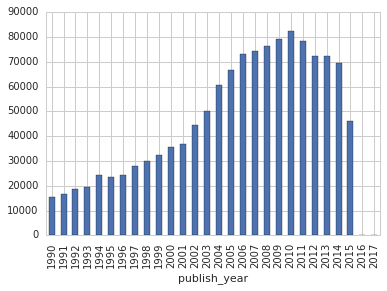

In [219]:
df_paper.groupby(['publish_year']).size().ix[1990:2017].plot(kind='bar')

In [220]:
df_paper.head()

,id,title,publish_year,publish_date,conference_id
0,85A60734,An Improvement of Tate Paring with Supersingul...,2015,2015/12,43510C43
1,07C653CA,A PRACTICAL APPROACH TO SUFFICIENT INFOSEC,1998,NaN,43510C43
2,7D62DF8B,Development of the Interactive Conference Syst...,2008,2008/01,43510C43
3,5A070C03,A Generic Distortion Free Watermarking Techniq...,2009,2009/11/15,43510C43
4,01027FF8,IFrandbox - Client Side Protection from Malici...,2011,2011/12/15,43510C43


# Get a2p from PaperAuthorAffiliations.txt

In [224]:
reader = pd.read_table(path+"PaperAuthorAffiliations.txt", \
                         names=['paper_id', 'author_id', 'affiliation_id', \
                                'origin_affiliation', 'normalize_affiliation', \
                                'seq_number'], iterator=True, low_memory=False)
loop = True
chunkSize = 1000000
chunks = []
cnt = 0
while loop:
    try:
        chunk = reader.get_chunk(chunkSize)
        tmp = pd.merge(chunk, df_paper, left_on='paper_id', right_on='id')
        tmp = tmp[['paper_id', 'author_id', 'affiliation_id', 'seq_number']]
        chunks.append(tmp)
        cnt += chunkSize
        print "Current: ", cnt, " time: ", time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time()))
    except StopIteration:
        loop = False
        print "Iteration is stopped."

df_a2p = pd.concat(chunks, ignore_index=True)

Current:  1000000  time:  2017-07-09 17:22:49
Current:  2000000  time:  2017-07-09 17:22:58
Current:  3000000  time:  2017-07-09 17:23:06
Current:  4000000  time:  2017-07-09 17:23:14
Current:  5000000  time:  2017-07-09 17:23:23
Current:  6000000  time:  2017-07-09 17:23:31
Current:  7000000  time:  2017-07-09 17:23:39
Current:  8000000  time:  2017-07-09 17:23:47
Current:  9000000  time:  2017-07-09 17:23:55
Current:  10000000  time:  2017-07-09 17:24:03
Current:  11000000  time:  2017-07-09 17:24:11
Current:  12000000  time:  2017-07-09 17:24:20
Current:  13000000  time:  2017-07-09 17:24:28
Current:  14000000  time:  2017-07-09 17:24:36
Current:  15000000  time:  2017-07-09 17:24:44
Current:  16000000  time:  2017-07-09 17:24:53
Current:  17000000  time:  2017-07-09 17:25:01
Current:  18000000  time:  2017-07-09 17:25:08
Current:  19000000  time:  2017-07-09 17:25:17
Current:  20000000  time:  2017-07-09 17:25:26
Current:  21000000  time:  2017-07-09 17:25:34
Current:  22000000  ti

Current:  174000000  time:  2017-07-09 17:38:37
Current:  175000000  time:  2017-07-09 17:38:43
Current:  176000000  time:  2017-07-09 17:38:48
Current:  177000000  time:  2017-07-09 17:38:54
Current:  178000000  time:  2017-07-09 17:39:00
Current:  179000000  time:  2017-07-09 17:39:06
Current:  180000000  time:  2017-07-09 17:39:13
Current:  181000000  time:  2017-07-09 17:39:19
Current:  182000000  time:  2017-07-09 17:39:25
Current:  183000000  time:  2017-07-09 17:39:31
Current:  184000000  time:  2017-07-09 17:39:37
Current:  185000000  time:  2017-07-09 17:39:44
Current:  186000000  time:  2017-07-09 17:39:50
Current:  187000000  time:  2017-07-09 17:39:56
Current:  188000000  time:  2017-07-09 17:40:02
Current:  189000000  time:  2017-07-09 17:40:09
Current:  190000000  time:  2017-07-09 17:40:15
Current:  191000000  time:  2017-07-09 17:40:21
Current:  192000000  time:  2017-07-09 17:40:28
Current:  193000000  time:  2017-07-09 17:40:33
Current:  194000000  time:  2017-07-09 1

In [225]:
#df_a2p[df_a2p.seq_number.isnull()]
df_a2p.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3904203 entries, 0 to 3904202
Data columns (total 4 columns):
paper_id          object
author_id         object
affiliation_id    object
seq_number        int64
dtypes: int64(1), object(3)
memory usage: 119.1+ MB


In [227]:
df_a2p[df_a2p.affiliation_id.notnull()]

,paper_id,author_id,affiliation_id,seq_number
0,7AE4FA25,84BF7F5E,077D5E0F,1
1,7AE4FA25,84CFA9DD,077D5E0F,2
2,8151D8C1,80887CE7,077D5E0F,2
3,8151D8C1,7D368371,077D5E0F,1
4,04AC5A07,7D90C348,077D5E0F,1
5,788884F0,84C7883A,07F5B6CA,2
6,788884F0,84A197FA,07F5B6CA,3
7,788884F0,7F3F93BA,07F5B6CA,4
8,788884F0,8512BDFB,07F5B6CA,1
9,7DFE80BC,79EA4AAD,07F5B6CA,5


In [228]:
df_a2p.to_csv(path+"df_a2p.csv", index=False)

**Statistics**: df_a2p: 3,904,203 items. 2,295,688 items's affiliation is NOT NAN

# Get affiliations and country

In [229]:
df_aff = pd.read_table(path+"Affiliations.txt", names=['aff_id', 'aff_name'])

In [8]:
df_grid = pd.read_csv(path+"grid.csv")

In [9]:
df_grid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74523 entries, 0 to 74522
Data columns (total 5 columns):
ID         74523 non-null object
Name       74523 non-null object
City       74523 non-null object
State      29492 non-null object
Country    74523 non-null object
dtypes: object(5)
memory usage: 2.8+ MB


In [10]:
#df_aff.info()
print df_aff.head()#[df_aff.aff_name.str.contains('tsinghua')]
print "-----------------------------------------------------------------"
print df_grid.head()

     aff_id                                       aff_name
0  0010A9BE  american association of school administrators
1  001E3D1D                    national trust for scotland
2  003EB1CB    mathematical institute university of oxford
3  0040BAC6           de la salle college of saint benilde
4  0041F649            mahanakorn university of technology
-----------------------------------------------------------------
            ID                            Name       City  \
0  grid.1001.0  Australian National University   Canberra   
1  grid.1002.3               Monash University  Melbourne   
2  grid.1003.2        University of Queensland   Brisbane   
3  grid.1004.5            Macquarie University     Sydney   
4  grid.1005.4                  UNSW Australia     Sydney   

                          State    Country  
0  Australian Capital Territory  Australia  
1                      Victoria  Australia  
2                    Queensland  Australia  
3               New South Wales  

In [21]:
#df_aff['country'] = np.nan #Add a new columns named country.

**Statistics**:

+ df_aff: 19,843 affiliations
+ df_grid: 74,523 affiliations. There is no NAN in country attribute.

In [73]:
df_res = df_grid[df_grid.Name.str.lower().str.contains('washington')].groupby(['Country']).size().sort_values(ascending=False)

In [74]:
df_res

Country
United States     110
United Kingdom      1
Norway              1
dtype: int64

In [55]:
i = 0
countries = []
for aff in df_aff['aff_name']:
    res = df_grid[df_grid.Name.str.lower()\
            .str.contains(aff)].groupby(['Country']).size().sort_values(ascending=False)
    if res.size == 0:
        # not exist in grid
        countries.append(np.nan)
        continue
    else:
        country = res.index[0] #the max match.
        countries.append(country) 
    i += 1
    if i % 1000 == 0:
        print "%d finished." %i
#print countries
print "All %d FINISHED!" %i

1000 finished.
2000 finished.
3000 finished.
4000 finished.
5000 finished.
6000 finished.
7000 finished.
8000 finished.
9000 finished.
10000 finished.
All 10324 FINISHED!


In [60]:
len(countries)

19843

In [56]:
df_aff['country'] = Series(countries)

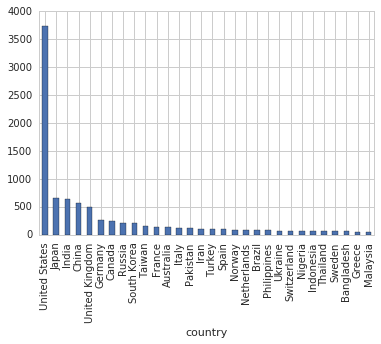

In [70]:
df_aff.groupby(['country']).size().sort_values(ascending=False)[:30].plot(kind='bar')

In [81]:
df_aff.groupby(['country']).size().sort_values(ascending=False)

country
United States               3735
Japan                        649
India                        639
China                        560
United Kingdom               489
Germany                      259
Canada                       248
Russia                       211
South Korea                  200
Taiwan                       147
France                       141
Australia                    137
Italy                        122
Pakistan                     114
Iran                         107
Turkey                        97
Spain                         93
Norway                        82
Netherlands                   82
Brazil                        75
Philippines                   73
Ukraine                       70
Switzerland                   69
Nigeria                       67
Indonesia                     66
Thailand                      65
Sweden                        61
Bangladesh                    55
Greece                        53
Malaysia                      51
  

In [103]:
pd.options.mode.chained_assignment = 'warn'

In [229]:
country = "Chinese"
df_aff[(df_aff['country'].isnull() \
       & df_aff['aff_name'].str.contains(country.lower()))]#['country'] #= country

,aff_id,aff_name,country


In [122]:
#Add country if affiliation name has particular country name, such as "United States".
cur_countries = df_aff.groupby(['country']).size().sort_values(ascending=False)
for country in cur_countries.index:
    df_aff.loc[(df_aff['country'].isnull() \
       & df_aff['aff_name'].str.contains(country.lower())), 'country'] = country

In [151]:
# State name from United States
state_name = df_grid[df_grid['Country']=='United States']['State'].unique()
state_name[state_name == 'District of Columbia'] = 'Columbia'

#Add country if affiliation name has particular state name, such as "New York".
for state in state_name:
    df_aff.loc[(df_aff['country'].isnull() \
       & df_aff['aff_name'].str.contains(state.lower())), 'country'] = 'United States'
    

In [191]:
#Find all affiliations which contains state name from every country
for country in cur_countries.index:
    state_name = df_grid[df_grid['Country']==country]['State'].dropna().unique()
    for state in state_name:
        df_aff.loc[(df_aff['country'].isnull() \
           & df_aff['aff_name'].str.contains(state.lower())), 'country'] = country
    print country, " finished!"

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """


United States  finished!
Japan  finished!
India  finished!
China  finished!
United Kingdom  finished!
Germany  finished!
Canada  finished!
Russia  finished!
South Korea  finished!
Taiwan  finished!
France  finished!
Australia  finished!
Italy  finished!
Pakistan  finished!
Iran  finished!
Turkey  finished!
Spain  finished!
Norway  finished!
Netherlands  finished!
Brazil  finished!
Philippines  finished!
Ukraine  finished!
Switzerland  finished!
Nigeria  finished!
Indonesia  finished!
Thailand  finished!
Sweden  finished!
Bangladesh  finished!
Greece  finished!
Malaysia  finished!
Austria  finished!
Poland  finished!
Finland  finished!
Egypt  finished!
Mexico  finished!
South Africa  finished!
Vietnam  finished!
Belgium  finished!
Ireland  finished!
Israel  finished!
Singapore  finished!
New Zealand  finished!
Saudi Arabia  finished!
Kenya  finished!
Argentina  finished!
Denmark  finished!
Portugal  finished!
Iraq  finished!
Colombia  finished!
United Arab Emirates  finished!
Czech Repu

In [224]:
#Find all best university from Canada
while True:
    university = raw_input("Please input university: ")
    #print university
    print "***********************RESULT************************"
    print df_aff[(df_aff['country'].isnull() \
           & df_aff['aff_name'].str.contains(university.lower()))].head()
    judge = raw_input("Insert is or not?[y/n]: ")
    if judge=='y':
        df_aff.loc[(df_aff['country'].isnull() \
               & df_aff['aff_name'].str\
                    .contains(university.lower())), 'country'] = "China"

Please input university: chinese
***********************RESULT************************
        aff_id                                           aff_name country
1201  023B6AC1        chinese people s public security university     NaN
2772  04C4A422        chinese people s armed police force academy     NaN
6143  4EEF08B3  chinese ministry of transportation and communi...     NaN
6515  4F208EF7               chinese ministry of economic affairs     NaN
9071  4CD41B82         chinese ministry of science and technology     NaN
Insert is or not?[y/n]: y


KeyboardInterrupt: 

Exact match (maybe error exists): 10,324/ 19,843

Following we can label it handly.

11,037 affiliation's countries are matched when we add country for name having country name.

11,605 affiliation's countries are matched considering state name in US.

12,092 affiliation's countries are matched considering state name in another countries.

12,667 affiliation's countries are matched considering top univeristies from US, Japan, India, China, UK, Germany, Canada and Australia

In [8]:
#Write affiliations with country in a csv file.
df_aff.to_csv(path + "df_aff.csv")

In [7]:
#import the affiliations with country
df_aff = pd.read_csv(path + "Affiliation_withCountry.csv")

# Get authors from Authors.txt

In [230]:
df_a2p = pd.read_csv(path+"df_a2p.csv")

/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [231]:
df_a2p.head()

,paper_id,author_id,affiliation_id,seq_number
0,7AE4FA25,84BF7F5E,077D5E0F,1
1,7AE4FA25,84CFA9DD,077D5E0F,2
2,8151D8C1,80887CE7,077D5E0F,2
3,8151D8C1,7D368371,077D5E0F,1
4,04AC5A07,7D90C348,077D5E0F,1


In [232]:
reader = pd.read_table(path+"Authors.txt", \
                         names=['author_id', 'author_name'],\
                       iterator=True)
loop = True
chunkSize = 1000000
chunks = []
cnt = 0
while loop:
    try:
        chunk = reader.get_chunk(chunkSize)
        tmp = pd.merge(chunk, df_a2p, left_on='author_id', right_on='author_id')
        tmp = tmp[['author_id', 'author_name']].drop_duplicates(['author_id'])
        chunks.append(tmp)
        cnt += chunkSize
        print "Current: ", cnt, " time: ", time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time()))
    except StopIteration:
        loop = False
        print "Iteration is stopped."

df_author = pd.concat(chunks, ignore_index=True)

Current:  1000000  time:  2017-07-09 19:45:23
Current:  2000000  time:  2017-07-09 19:45:27
Current:  3000000  time:  2017-07-09 19:45:32
Current:  4000000  time:  2017-07-09 19:45:36
Current:  5000000  time:  2017-07-09 19:45:41
Current:  6000000  time:  2017-07-09 19:45:45
Current:  7000000  time:  2017-07-09 19:45:50
Current:  8000000  time:  2017-07-09 19:45:55
Current:  9000000  time:  2017-07-09 19:46:00
Current:  10000000  time:  2017-07-09 19:46:04
Current:  11000000  time:  2017-07-09 19:46:09
Current:  12000000  time:  2017-07-09 19:46:13
Current:  13000000  time:  2017-07-09 19:46:18
Current:  14000000  time:  2017-07-09 19:46:21
Current:  15000000  time:  2017-07-09 19:46:25
Current:  16000000  time:  2017-07-09 19:46:28
Current:  17000000  time:  2017-07-09 19:46:33
Current:  18000000  time:  2017-07-09 19:46:37
Current:  19000000  time:  2017-07-09 19:46:42
Current:  20000000  time:  2017-07-09 19:46:45
Current:  21000000  time:  2017-07-09 19:46:50
Current:  22000000  ti

In [233]:
df_author.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1283973 entries, 0 to 1283972
Data columns (total 2 columns):
author_id      1283973 non-null object
author_name    1283970 non-null object
dtypes: object(2)
memory usage: 19.6+ MB


In [234]:
df_author.to_csv(path+"df_author.csv", index=False)

df_author: 1,283,973

# Modify csv file

In [44]:
df_conference = pd.read_csv(path+"df_conference.csv")
df_paper = pd.read_csv(path+"df_paper.csv")
df_a2p = pd.read_csv(path+"df_a2p.csv")
df_aff = pd.read_csv(path+"df_aff.csv")
df_author = pd.read_csv(path+"df_author.csv")

/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [45]:
df_aff.columns

Index([u'aff_id', u'aff_name', u'country'], dtype='object')

In [38]:
df_aff.drop('Unnamed: 0.1',axis=1, inplace=True)

In [46]:
df_aff.head()

,aff_id,aff_name,country
0,0010A9BE,american association of school administrators,United States
1,001E3D1D,national trust for scotland,United Kingdom
2,003EB1CB,mathematical institute university of oxford,United Kingdom
3,0040BAC6,de la salle college of saint benilde,NaN
4,0041F649,mahanakorn university of technology,Thailand


In [43]:
df_conference.to_csv(path+"df_conference.csv", index=False)
df_paper.to_csv(path+"df_paper.csv", index=False)
df_a2p.to_csv(path+"df_a2p.csv", index=False)
df_aff.to_csv(path+"df_aff.csv", index=False)
df_author.to_csv(path+"df_author.csv", index=False)

# Get reference from PaperReferences.txt

In [235]:
reader = pd.read_table(path+"PaperReferences.txt", \
                         names=['dst_id', 'src_id'],\
                       iterator=True)
loop = True
chunkSize = 1000000
chunks = []
cnt = 0
while loop:
    try:
        chunk = reader.get_chunk(chunkSize)
        tmp = pd.merge(chunk, df_paper, left_on='src_id', right_on='id')
        tmp = tmp[['src_id', 'dst_id']]
        chunks.append(tmp)
        cnt += chunkSize
        print "Current: ", cnt, " time: ", time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time()))
    except StopIteration:
        loop = False
        print "Iteration is stopped."

df_relationship = pd.concat(chunks, ignore_index=True)

Current:  1000000  time:  2017-07-10 08:48:33
Current:  2000000  time:  2017-07-10 08:48:39
Current:  3000000  time:  2017-07-10 08:48:45
Current:  4000000  time:  2017-07-10 08:48:49
Current:  5000000  time:  2017-07-10 08:48:53
Current:  6000000  time:  2017-07-10 08:48:57
Current:  7000000  time:  2017-07-10 08:49:03
Current:  8000000  time:  2017-07-10 08:49:05
Current:  9000000  time:  2017-07-10 08:49:09
Current:  10000000  time:  2017-07-10 08:49:14
Current:  11000000  time:  2017-07-10 08:49:19
Current:  12000000  time:  2017-07-10 08:49:23
Current:  13000000  time:  2017-07-10 08:49:27
Current:  14000000  time:  2017-07-10 08:49:32
Current:  15000000  time:  2017-07-10 08:49:35
Current:  16000000  time:  2017-07-10 08:49:38
Current:  17000000  time:  2017-07-10 08:49:40
Current:  18000000  time:  2017-07-10 08:49:44
Current:  19000000  time:  2017-07-10 08:49:47
Current:  20000000  time:  2017-07-10 08:49:50
Current:  21000000  time:  2017-07-10 08:49:53
Current:  22000000  ti

Current:  174000000  time:  2017-07-10 09:00:27
Current:  175000000  time:  2017-07-10 09:00:32
Current:  176000000  time:  2017-07-10 09:00:36
Current:  177000000  time:  2017-07-10 09:00:41
Current:  178000000  time:  2017-07-10 09:00:46
Current:  179000000  time:  2017-07-10 09:00:50
Current:  180000000  time:  2017-07-10 09:00:55
Current:  181000000  time:  2017-07-10 09:01:00
Current:  182000000  time:  2017-07-10 09:01:05
Current:  183000000  time:  2017-07-10 09:01:09
Current:  184000000  time:  2017-07-10 09:01:14
Current:  185000000  time:  2017-07-10 09:01:19
Current:  186000000  time:  2017-07-10 09:01:24
Current:  187000000  time:  2017-07-10 09:01:28
Current:  188000000  time:  2017-07-10 09:01:33
Current:  189000000  time:  2017-07-10 09:01:38
Current:  190000000  time:  2017-07-10 09:01:43
Current:  191000000  time:  2017-07-10 09:01:47
Current:  192000000  time:  2017-07-10 09:01:52
Current:  193000000  time:  2017-07-10 09:01:57
Current:  194000000  time:  2017-07-10 0

Current:  345000000  time:  2017-07-10 09:12:02
Current:  346000000  time:  2017-07-10 09:12:07
Current:  347000000  time:  2017-07-10 09:12:12
Current:  348000000  time:  2017-07-10 09:12:16
Current:  349000000  time:  2017-07-10 09:12:21
Current:  350000000  time:  2017-07-10 09:12:26
Current:  351000000  time:  2017-07-10 09:12:30
Current:  352000000  time:  2017-07-10 09:12:35
Current:  353000000  time:  2017-07-10 09:12:40
Current:  354000000  time:  2017-07-10 09:12:45
Current:  355000000  time:  2017-07-10 09:12:49
Current:  356000000  time:  2017-07-10 09:12:54
Current:  357000000  time:  2017-07-10 09:12:59
Current:  358000000  time:  2017-07-10 09:13:04
Current:  359000000  time:  2017-07-10 09:13:09
Current:  360000000  time:  2017-07-10 09:13:13
Current:  361000000  time:  2017-07-10 09:13:18
Current:  362000000  time:  2017-07-10 09:13:23
Current:  363000000  time:  2017-07-10 09:13:28
Current:  364000000  time:  2017-07-10 09:13:33
Current:  365000000  time:  2017-07-10 0

Current:  516000000  time:  2017-07-10 09:27:09
Current:  517000000  time:  2017-07-10 09:27:15
Current:  518000000  time:  2017-07-10 09:27:21
Current:  519000000  time:  2017-07-10 09:27:26
Current:  520000000  time:  2017-07-10 09:27:31
Current:  521000000  time:  2017-07-10 09:27:38
Current:  522000000  time:  2017-07-10 09:27:45
Current:  523000000  time:  2017-07-10 09:27:52
Current:  524000000  time:  2017-07-10 09:27:57
Current:  525000000  time:  2017-07-10 09:28:02
Current:  526000000  time:  2017-07-10 09:28:07
Current:  527000000  time:  2017-07-10 09:28:12
Current:  528000000  time:  2017-07-10 09:28:19
Current:  529000000  time:  2017-07-10 09:28:23
Iteration is stopped.


In [236]:
df_relationship.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807178 entries, 0 to 8807177
Data columns (total 2 columns):
src_id    object
dst_id    object
dtypes: object(2)
memory usage: 134.4+ MB


df_relationship: 8,807,178 items including **all src_id** belong to df_paper

In [237]:
df_relationship.to_csv(path+"df_relationship.csv", index=False)

# Get all paper's country



We regard the first author's country as paper's country

In [239]:
df_aff = pd.read_csv(path+"df_aff.csv")

In [240]:
#df_a2p.drop_duplicates(['paper_id'])
df_tmp = df_a2p[df_a2p['seq_number'] == 1]
df_tmp2 = pd.merge(df_aff, \
                   pd.merge(df_tmp, df_paper, left_on='paper_id', right_on='id'),\
                   left_on = 'aff_id', right_on='affiliation_id')

df_tmp2 = df_tmp2[['paper_id', 'title', 'publish_year', 'aff_name', 'country', 'conference_id']]

In [241]:
df_tmp2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 907177 entries, 0 to 907176
Data columns (total 6 columns):
paper_id         907177 non-null object
title            907177 non-null object
publish_year     907177 non-null int64
aff_name         907177 non-null object
country          816523 non-null object
conference_id    907177 non-null object
dtypes: int64(1), object(5)
memory usage: 48.4+ MB


We get 907,177 papers including paper_id, title, publish_year, affiliation_name, country, conference_id.

Specially, only country includes NAN and **<font color=#ff0000>816,523</font>** is not NAN

In [242]:
df_tmp3 = pd.merge(df_tmp2, df_conference, left_on='conference_id', right_on='con_id')

In [243]:
df_tmp3 = df_tmp3[['paper_id', 'title', 'publish_year', 'aff_name', 'country', 'con_id', 'con_abbr']]

In [244]:
df_tmp3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 907177 entries, 0 to 907176
Data columns (total 7 columns):
paper_id        907177 non-null object
title           907177 non-null object
publish_year    907177 non-null int64
aff_name        907177 non-null object
country         816523 non-null object
con_id          907177 non-null object
con_abbr        907177 non-null object
dtypes: int64(1), object(6)
memory usage: 55.4+ MB


In [245]:
df_tmp3.to_csv(path+"df_paper_withcountry.csv", index=False)

# Journals data

In [8]:
df_journal = pd.read_table(path+"Journals.txt", names=['journal_id', 'journal_name'])

In [12]:
reader = pd.read_table(path+"Papers.txt", \
                         names=['paper_id', 'paper_title', \
                                'normalize_title', \
                                'publish_year', \
                                'publish_date', \
                                'DOI', \
                                'venue_name', \
                                'normalize_venuename', \
                                'journal_id', 'conference_id', 'paper_rank'], iterator=True, low_memory=False)
loop = True
chunkSize = 1000000
chunks = []
cnt = 0
while loop:
    try:
        chunk = reader.get_chunk(chunkSize)
        tmp = pd.merge(chunk, df_journal, left_on='journal_id', right_on='journal_id')
        tmp = tmp[['paper_id', 'paper_title', 'publish_year', 'publish_date', 'journal_id', 'conference_id']]
        chunks.append(tmp)
        cnt += chunkSize
        print "Current: ", cnt, " time: ", time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time()))
    except StopIteration:
        loop = False
        print "Iteration is stopped."

df_paper = pd.concat(chunks, ignore_index=True)
# df_paper = reader.get_chunk(chunkSize)

Current:  1000000  time:  2017-07-11 21:33:01
Current:  2000000  time:  2017-07-11 21:33:15
Current:  3000000  time:  2017-07-11 21:33:28
Current:  4000000  time:  2017-07-11 21:33:43
Current:  5000000  time:  2017-07-11 21:33:59
Current:  6000000  time:  2017-07-11 21:34:15
Current:  7000000  time:  2017-07-11 21:34:32
Current:  8000000  time:  2017-07-11 21:34:48
Current:  9000000  time:  2017-07-11 21:35:08
Current:  10000000  time:  2017-07-11 21:35:25
Current:  11000000  time:  2017-07-11 21:35:43
Current:  12000000  time:  2017-07-11 21:36:03
Current:  13000000  time:  2017-07-11 21:36:17
Current:  14000000  time:  2017-07-11 21:36:34
Current:  15000000  time:  2017-07-11 21:36:49
Current:  16000000  time:  2017-07-11 21:37:05
Current:  17000000  time:  2017-07-11 21:37:23
Current:  18000000  time:  2017-07-11 21:37:41
Current:  19000000  time:  2017-07-11 21:37:55
Current:  20000000  time:  2017-07-11 21:38:10
Current:  21000000  time:  2017-07-11 21:38:20
Current:  22000000  ti

In [11]:
df_journal[df_journal['journal_id']=='09ED24F9']

,journal_id,journal_name
14280,09ED24F9,International Journal of Clinical Pharmacology...


In [15]:
df_journal[:4]

,journal_id,journal_name
0,0950B41C,California Agriculture
1,013A68A4,AIDS
2,030F0139,Early Music History
3,00C5DF18,Statistical Science


In [16]:
def get_five(df_paper, n=5):
    return df_paper[df_paper['conference_id'].isnull()][:5]

In [18]:
df_tmp = df_paper.groupby(['journal_id']).apply(get_five)

In [7]:
df_tmp.to_csv(path+"dblp_source.csv", index=False)

In [8]:
df_tmp = pd.read_csv(path+"dblp_source.csv")

In [9]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111747 entries, 0 to 111746
Data columns (total 6 columns):
paper_id         111747 non-null object
paper_title      111747 non-null object
publish_year     111747 non-null int64
publish_date     107372 non-null object
journal_id       111747 non-null object
conference_id    0 non-null float64
dtypes: float64(1), int64(1), object(4)
memory usage: 5.1+ MB


In [10]:
df_tmp.head()

,paper_id,paper_title,publish_year,publish_date,journal_id,conference_id
0,59EF9ACB,Pilot Evaluation of Four Experimental Conditio...,2011,2011/02/01,0000F0DD,NaN
1,754C468B,The pen is mightier…,2000,2000/06/01,0000F0DD,NaN
2,75959CC2,An Investigation of the Rheological Properties...,1993,1993/09/01,0000F0DD,NaN
3,760C8336,Extremely timely subject,2001,2001/12/01,0000F0DD,NaN
4,76892DC8,Relative wear of enamel opposing low-fusing de...,2003,2003/09/01,0000F0DD,NaN


In [11]:
# Crawler from dblp
import requests
from bs4 import BeautifulSoup
from time import sleep

In [12]:
#input:paper_title, return:dblpname
def warnInfo(string):
    #with open("venue_log.txt","a") as fp:
    #	fp.write(string+'\n')
    print string


class extractPaper(object):
    def __init__(self,url, headers, paper_title):
        #print "__init__"
        self.url = url
        self.headers = headers
        self.paper_title = paper_title

    def _requestWeb(self):
        #print "_requestWeb"
        cnt_res = 1
        while(cnt_res <= 5):
            #print "VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV"
            try:
                response = requests.get(self.url, headers = self.headers, timeout=10)
                return response
            except:
                cnt_res += 1
                continue
        raise Exception #如果链接失败，则抛出异常，被调用函数捕获

    def _getDblp(self, li):
        #print "_getDblp"
        try:
            cur_title = li.find('span', attrs={'class':'title', 'itemprop':'name'}).text
        except:
            print "NO NAME???"
            raise Exception
        #末尾都加上.
        if cur_title[-1] != '.':
            cur_title += '.'
        paper_title = self.paper_title
        if paper_title[-1] != '.':
            paper_title += '.'
        #去掉所有空格并转为小写字母，比较两个题目是否完全相同
        cur_title_temp = cur_title.replace(" ","").lower()
        paper_title_temp = paper_title.replace(" ", "").lower()
        if cur_title_temp != paper_title_temp:
            warnInfo("The two papers are different!\nCurrent: '%s'\nOrigin: '%s'\n"%(cur_title, paper_title))
            raise Exception
        else:
            #匹配成功
            try:
                dblpname = li.find('span', attrs={'itemprop':'isPartOf'}).text
            except:
                print "NO isPartOf???"
                raise Exception
        return dblpname


    def _parse(self, response):
        #print "_parse"
        assert type(response) == requests.models.Response #判断response类型
        soup = BeautifulSoup(response.text)
        try:
            #判断是否可以匹配到
            match = soup.find(id='completesearch-info-matches').text
        except:
            warnInfo("Matches FAILED!")
            raise Exception

        if ((match != "found one match") and (match != "found 1 match")):
            warnInfo(match)
            raise Exception
        else:
            #只有一个匹配
            ul = soup.find('ul', attrs={'class':'publ-list'})
            try:
                li = ul.find('li', attrs={'class':'entry article'})			
                if li is None:
                    #说明不是期刊论文
                    raise Exception
                else:
                    #期刊论文
                    dblpname = self._getDblp(li)
            except:
                warnInfo("Get dblpname FAILED!")
                raise Exception
        return dblpname

    def crawlWeb(self):
        #print "crawlWeb"
        try:
            response = self._requestWeb()
        except:
            warnInfo("Connection FAILED! The url is: " + self.url)
            raise Exception
        try:
            #获取网页成功
            dblpname = self._parse(response)	
        except:
            #获取网页失败
            #warnInfo("Parser is FAILED! The url is: " + self.url)
            raise Exception #
        return dblpname #返回dblpname值

In [13]:
headers = { 
            'Host':'dblp.uni-trier.de',
            'User-Agent': 'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/55.0.2883.87 Safari/537.36',
            'Accept':'text/javascript, application/javascript, application/ecmascript, application/x-ecmascript, */*; q=0.01',
            'Accept-Language':'zh-CN,zh;q=0.8,en-US;q=0.6,en;q=0.4',
            'Accept-Encoding':'gzip, deflate, sdch',
            'Referer':'http://dblp.uni-trier.de/',
            'Cookie': 'dblp-hideable-show-feeds=true; dblp-hideable-show-rawdata=true; dblp-view=y; dblp-search-mode=c',
            'Connection':'keep-alive',
            'Cache-Control':'max-age=0',}

In [18]:
def get_dblpname(paper_title, headers):
    paper_title = str(paper_title)
    if paper_title[-1] != '.':
        paper_title += '.'
    line = paper_title.replace("%","%25").replace(" ", "%20").replace(",", "%2C").replace(":", "%3A").replace("?", "%3F").replace("&", "%26").replace("'","%27")
    url = "http://dblp.uni-trier.de/search?q=" + line
    
    cur_extract = extractPaper(url, headers, paper_title)
    try:
        dblpname = cur_extract.crawlWeb()
    except:
        dblpname = "NOT IN DBLP"
        
    try:
        return str(dblpname)
    except:
        return dblpname

def get_journal_dblpname(df_tmp, journal_id, headers):
    df_cur = df_tmp[df_tmp.journal_id == journal_id]['paper_title']
    title_set = df_cur.reset_index()['paper_title']
    for paper_title in title_set:
        dblpname = get_dblpname(paper_title, headers)
        if dblpname == 'NOT IN DBLP':
            continue
        else:
            break
    return dblpname

In [ ]:
cnt = 0
dic = {}
for journal_id in df_tmp['journal_id'].unique():
    #raise Exception
    print "********************************************************************"
    
    dblpname = get_journal_dblpname(df_tmp, journal_id, headers)
    dic[journal_id] = dblpname
    print cnt, '--------', journal_id, " : ", dblpname
    cnt +=1

In [ ]:
dic

In [51]:
str(get_dblpname('Citation regression analysis of computer science publications in different ranking categories and subfields', headers))

'Scientometrics'

In [43]:
get_dblpname('An Extended Technology Acceptance Model for Mobile Social Gaming Service Popularity Analysis', headers)

u'Mobile Information Systems'

In [18]:
df_paper3

NameError: name 'df_paper3' is not defined